# Machine learning project

## Import librarys

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
from datetime import timedelta
import pandas_profiling
from sklearn.preprocessing import StandardScaler
import seaborn as sn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from dateutil.rrule import rrule, MONTHLY
from dateutil.parser import parse
import requests
from bs4 import BeautifulSoup
#from sklearn.linear_model import Ridge, Lasso, ElasticNet

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Functions

In [2]:
# import data to data frame from url us 'Obs' elements
def imp_data(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'xml')
    obs_elements = soup.find_all('Obs')
    data = []
    for obs in obs_elements:
        row = {}
        for attr in obs.attrs:
            row[attr] = obs.attrs[attr]
        data.append(row)
    df = pd.DataFrame(data)
    return df 

#get list of url and bring back list with the data from the url
def list_url_t0_data_list(full_URL):
    index = 0
    data = list()
    for url in full_URL:
        x = imp_data(url)
        data.append(x)
    return data

# Merge and group list by month and mean for there 'OBS_VALUE'
def merge_and_group_dt(full_data, col_names):
    new_df = pd.DataFrame()
    index = 0
    for df in full_data:    
        M_sum = pd.DataFrame()
        df1 = pd.DataFrame()
        df1['TIME_PERIOD'] = df['TIME_PERIOD']
        df1[col_names[index]] = numpy.float64(df['OBS_VALUE'])
        df1['TIME_PERIOD'] = pd.to_datetime(df1['TIME_PERIOD'])
        M_sum = df1.groupby(pd.Grouper(key='TIME_PERIOD', freq='M')).mean()
        if new_df.empty:
            new_df = M_sum
        else:
            new_df = pd.merge(new_df, M_sum, on='TIME_PERIOD')    
        index = index+1
    return new_df

#plot predict and real data by month with std 
def plot_predict_std(startdt, enddt, y, predict, title):
    dates_by_month = list(rrule(MONTHLY, dtstart=parse(startdt), until=parse(enddt)))
    df_p = pd.DataFrame({'dates_by_month': dates_by_month, 'TIME_PERIOD': predict})
    plt.errorbar(df_p['dates_by_month'], df_p['TIME_PERIOD'], np.std(predict),label='predict', fmt='.k', ecolor='lightgray')
    plt.title(title)
    plt.plot(y, label='real rate')
    plt.legend()
    plt.show()
    
#plot predict and real data by month     
def plot_predict(startdt, enddt, y, predict, title):
    dates_by_month = list(rrule(MONTHLY, dtstart=parse(startdt), until=parse(enddt)))
    df_p = pd.DataFrame({'dates_by_month': dates_by_month, 'TIME_PERIOD': predict})
    plt.plot(df_p['dates_by_month'], df_p['TIME_PERIOD'], label='predict')
    plt.title(title)
    plt.plot(y, label='real rate')
    plt.legend()
    plt.show()
    
# Us plot_predict and plot_predict_std together  
def plot_predict_and_std(startdt, enddt, y, predict, title):   
    plot_predict(startdt, enddt, y, predict, title)
    plot_predict_std(startdt, enddt, y, predict, title)
    
#calculate Adj R2
def Adj_R2(r2, X_train, X):
    r2 = r2
    n= len(X_train)
    p = len(X.columns)
    adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1)) #Adj R2 = 1-(1-R2)*(n-1)/(n-p-1)
    return adj_R2

#add Adj R2 to df
def add_Adj_R2(full_eva, X_train, X):
    lis = list()
    for r2 in full_eva['r2_score']:
        lis.append(Adj_R2(r2, X_train, X))        
    full_eva['Adj_R2'] = lis
    return full_eva

# return Model evaluate r2_score and MSE
def Model_Evaluate(X_test, y_test, fit_modle, modle_name):
    results = dict()
    y_pred = fit_modle.predict(X_test)
    results['modle_name'] = modle_name
    results['MSE'] = mean_squared_error(y_test, y_pred)
    results['r2_score'] = r2_score(y_test, y_pred)
    
    return results 

#print the MSE for train and test data
def fitting_MSE(modke_fit, X_train, X_test, y_train):

    train_predictions = modke_fit.predict(X_train)
    test_predictions = modke_fit.predict(X_test)
    train_mse = mean_squared_error(y_train, train_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)

    print(f"Training MSE: {train_mse:.4f}")
    print(f"Testing MSE: {test_mse:.4f}")

## DATA

### URL

In [3]:
exchange_Rate_URL = 'https://edge.boi.gov.il/FusionEdgeServer/sdmx/v2/data/dataflow/BOI.STATISTICS/EXR/1.0/RER_USD_ILS.D.USD.ILS.ILS.OF00?locale=en'
MCM_URL = 'https://edge.boi.gov.il/FusionEdgeServer/sdmx/v2/data/dataflow/BOI.STATISTICS/ACC/1.0/ACC_MKM2600065_S_B_ME.M.ILS.L1000.L.STK.S1?locale=en'
Currency_in_Circulation_URL = 'https://edge.boi.gov.il/FusionEdgeServer/sdmx/v2/data/dataflow/BOI.STATISTICS/ACC/1.0/CIC_VAL_TOT_M.M.ILS.L0100.L.STK.S1?locale=en'
Foreign_exchange_Reserves_URL = 'https://edge.boi.gov.il/FusionEdgeServer/sdmx/v2/data/dataflow/BOI.STATISTICS/ACC/1.0/ACC_RES2700018_D_B_ME.M.USD.L150200._Z.STK._Z?locale=en'
Trade_Bank_URL = 'https://edge.boi.gov.il/FusionEdgeServer/sdmx/v2/data/dataflow/BOI.STATISTICS/DRV/1.0/WEB_TV_OPTN_IL_LB.D.NAT.F711A.W2.S122_X_FB_L.W2.S122_X_FB_L._X.FX?locale=en'
Trade_Residents_URL = 'https://edge.boi.gov.il/FusionEdgeServer/sdmx/v2/data/dataflow/BOI.STATISTICS/DRV/1.0/WEB_TV_SWAP_NR.D.NAT.F712C.W29.S2_L.W2.S122_X_FB_L._X.FX?locale=en'
Trade_Foreign_URL = 'https://edge.boi.gov.il/FusionEdgeServer/sdmx/v2/data/dataflow/BOI.STATISTICS/DRV/1.0/WEB_TV_SWAP_NR_FI.D.NAT.F712C.W29.S2_S12_L.W2.S122_X_FB_L._X.FX?locale=en'
Trade_Foreign_Institutions_URL = 'https://edge.boi.gov.il/FusionEdgeServer/sdmx/v2/data/dataflow/BOI.STATISTICS/DRV/1.0/WEB_TV_OPTN_IL.D.NAT.F711A.W2.S1.W2.S122_X_FB_L._X.FX?locale=en'
Offered_Rate_URL = 'https://edge.boi.gov.il/FusionEdgeServer/sdmx/v2/data/dataflow/BOI.STATISTICS/TLB/1.0/TLBR_01M_D.D.TLBR_01M?locale=en'
Fruits_And_Vegetables_URL = 'https://edge.boi.gov.il/FusionEdgeServer/sdmx/v2/data/dataflow/BOI.STATISTICS/PRI/1.0/CP000000.CPI.CPI_5_0_3.MAIN.M.N._Z._Z.I22_L._Z.A._Z._Z.CP_00?locale=en'

full_URL = [exchange_Rate_URL, MCM_URL, Currency_in_Circulation_URL, Foreign_exchange_Reserves_URL, Trade_Bank_URL, Trade_Residents_URL, Trade_Foreign_URL, Trade_Foreign_Institutions_URL, Offered_Rate_URL, Fruits_And_Vegetables_URL]
col_names = ["exchange_Rate", "MCM", "Currency_in_Circulation", "Foreign_exchange_Reserves" ,"Trade_Bank" , "Trade_Residents", "Trade_Foreign", "Trade_Foreign_Institutions", "Offered_Rate", "Fruits_And_Vegetables"]

### Connecting and summariz data by month

In [4]:
full_data = list_url_t0_data_list(full_URL)
new_df = merge_and_group_dt(full_data, col_names)

### Exchange rate by day all data

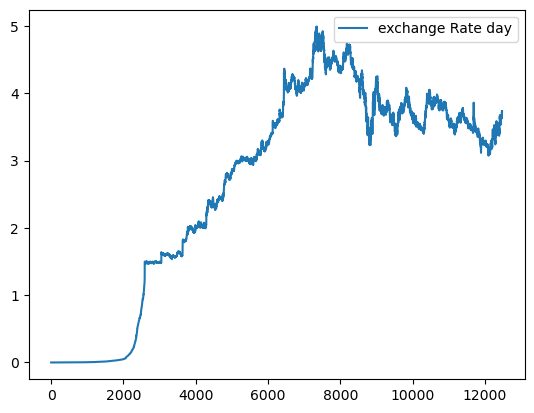

In [5]:
plt.plot(numpy.float64(full_data[0]['OBS_VALUE']), label='exchange Rate day')
plt.legend()

### First exploration of the data

In [6]:
new_df

,exchange_Rate,MCM,Currency_in_Circulation,Foreign_exchange_Reserves,Trade_Bank,Trade_Residents,Trade_Foreign,Trade_Foreign_Institutions,Offered_Rate,Fruits_And_Vegetables
TIME_PERIOD,,,,,,,,,,
2008-01-31,3.750909,75462.379278,28723.655994,28713.324736,93.447619,1742.179544,1741.854483,420.395379,4.513913,76.397184
2008-02-29,3.608429,74977.759528,28668.732322,28582.611943,84.788796,1753.799717,1753.657738,286.219984,4.406190,81.319848
2008-03-31,3.510850,74443.534456,29471.479129,29539.300388,76.559980,2193.817056,2308.429996,366.685978,3.837619,77.036491
2008-04-30,3.519682,74505.871770,30544.066859,29478.273069,45.924171,1527.003366,1526.672535,244.388227,3.613636,80.936263
2008-05-31,3.378800,74618.587865,30304.159961,29958.334676,61.198410,1745.418153,1745.059061,297.579931,3.758571,80.936263
...,...,...,...,...,...,...,...,...,...,...
2022-12-31,3.451571,210127.167986,119426.089146,194217.921190,49.664968,2460.881548,2577.394955,195.062620,3.387667,98.233557
2023-01-31,3.445286,236245.127388,118543.628955,200984.939485,57.029232,3119.658391,3119.365740,309.368394,3.765095,97.900000
2023-02-28,3.543150,251431.448747,118880.495500,196279.326725,60.957159,2480.595439,2480.595439,437.913939,4.034579,100.900000


In [7]:
sdt = str(new_df.index.min())
edtsdt = str(new_df.index.max())
startdt = sdt[0:8]+'01'
enddt = edtsdt[0:8]+'01'

### Look with pandas_profiling

In [8]:
# import pandas_profiling
# profile = new_df.profile_report()
# profile.to_file(output_file="output.html")## Connecting and summarizing data

### Exchange rate and the features

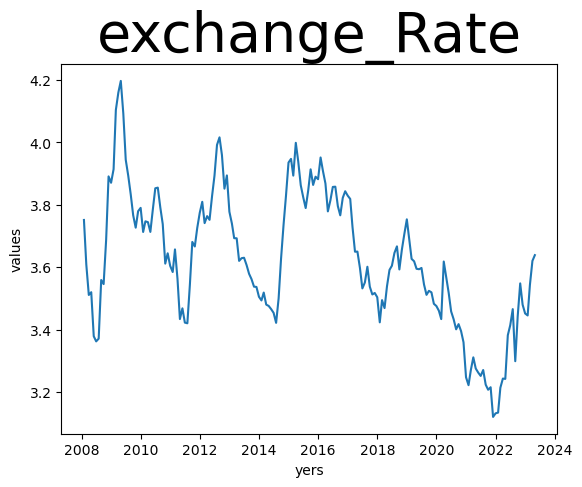

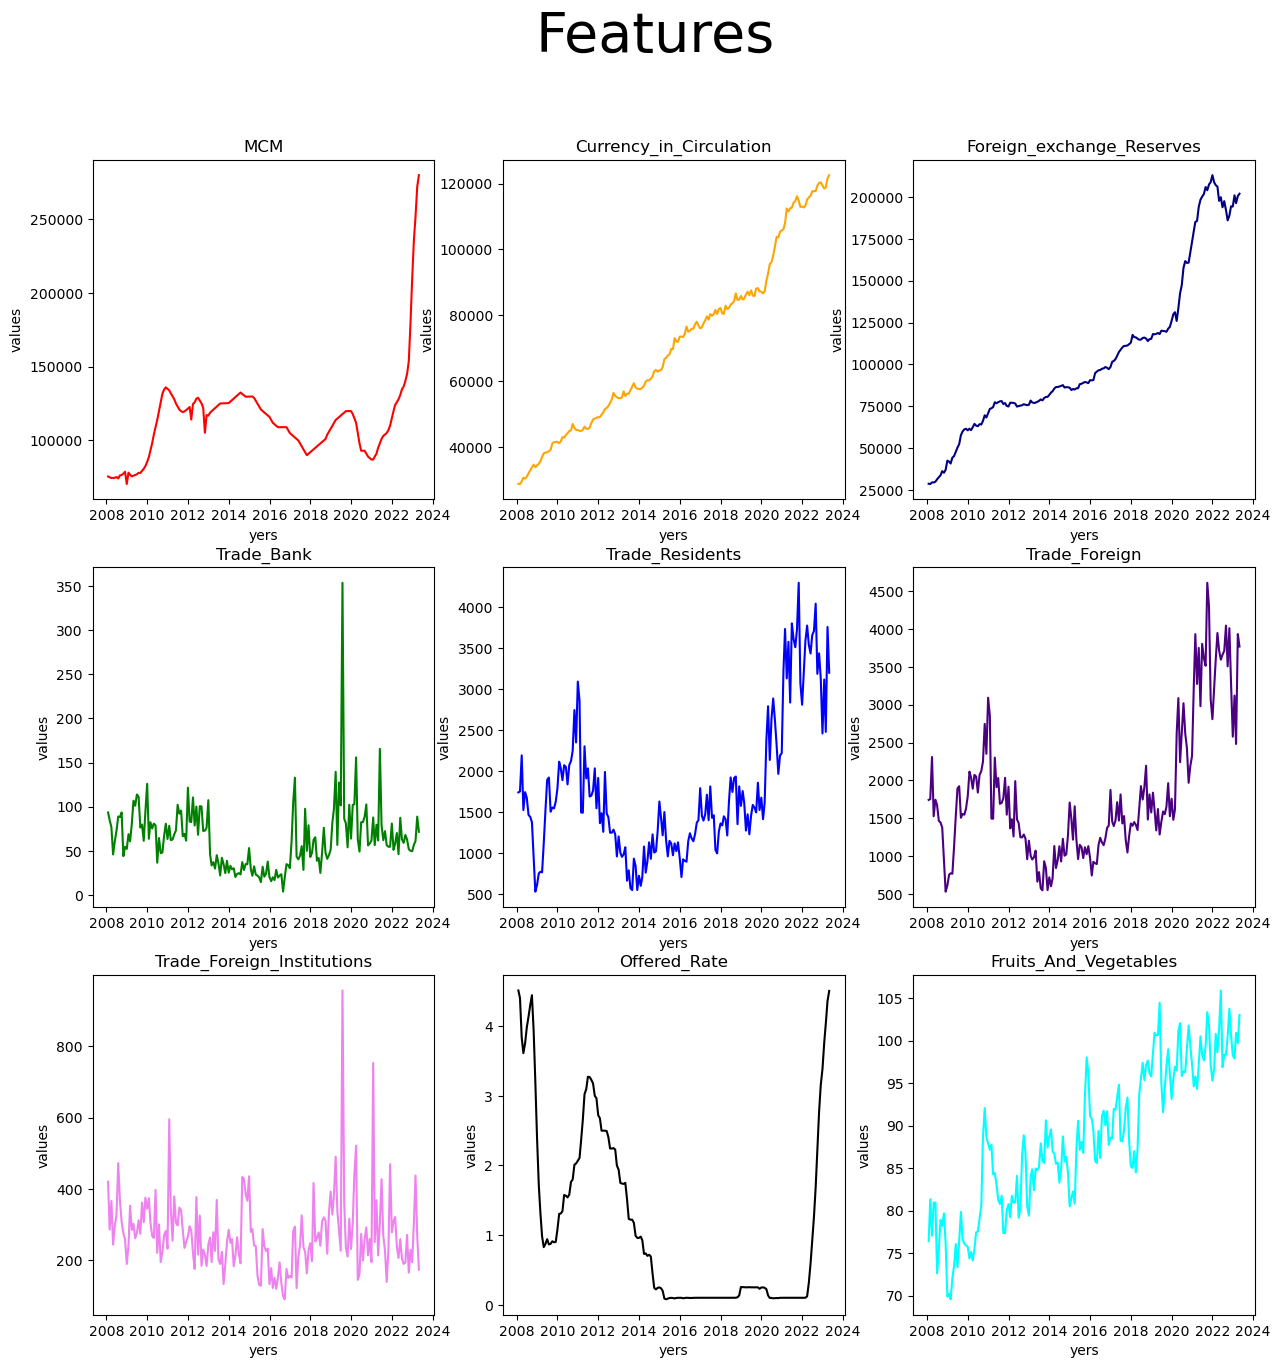

In [9]:
plt.plot(new_df["exchange_Rate"])
plt.xlabel("yers")
plt.ylabel("values")
plt.title("exchange_Rate", fontsize=40)


fig, axs = plt.subplots(3, 3, figsize=(15, 15))#, sharey=True)
colors = ['red', 'orange', 'navy', 'green', 'blue', 'indigo', 'violet', 'black', 'cyan']
index = 1
for i in range(0,3):
    for j in range(0,3):
        axs[i][j].plot(new_df[col_names[index]], color = colors[index-1] )
        axs[i][j].set_title(col_names[index])
        axs[i][j].set_xlabel("yers")
        axs[i][j].set_ylabel("values")  
        index = index + 1   
fig.suptitle('Features', fontsize=40)
plt.show()

### Check correlations

In [10]:
corr = new_df.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=2)

,exchange_Rate,MCM,Currency_in_Circulation,Foreign_exchange_Reserves,Trade_Bank,Trade_Residents,Trade_Foreign,Trade_Foreign_Institutions,Offered_Rate,Fruits_And_Vegetables
exchange_Rate,1.00,-0.07,-0.57,-0.66,-0.10,-0.59,-0.59,-0.16,0.06,-0.54
MCM,-0.07,1.00,0.37,0.39,-0.11,0.24,0.26,-0.06,0.28,0.36
Currency_in_Circulation,-0.57,0.37,1.00,0.97,0.00,0.62,0.64,-0.07,-0.44,0.89
Foreign_exchange_Reserves,-0.66,0.39,0.97,1.00,0.05,0.73,0.75,-0.02,-0.34,0.84
Trade_Bank,-0.10,-0.11,0.00,0.05,1.00,0.22,0.21,0.60,0.16,-0.02
Trade_Residents,-0.59,0.24,0.62,0.73,0.22,1.00,0.99,0.12,0.04,0.50
Trade_Foreign,-0.59,0.26,0.64,0.75,0.21,0.99,1.00,0.10,0.04,0.53
Trade_Foreign_Institutions,-0.16,-0.06,-0.07,-0.02,0.60,0.12,0.10,1.00,0.10,-0.07
Offered_Rate,0.06,0.28,-0.44,-0.34,0.16,0.04,0.04,0.10,1.00,-0.41
Fruits_And_Vegetables,-0.54,0.36,0.89,0.84,-0.02,0.50,0.53,-0.07,-0.41,1.00


### Describe data

In [11]:
new_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
exchange_Rate,184.0,3.624935,0.216791,3.120500,3.478623,3.614566,3.789159,4.195938
MCM,184.0,113659.106614,29924.391519,70398.060475,95938.775130,114487.714423,125150.968455,279953.965939
Currency_in_Circulation,184.0,71274.918263,26241.069051,28668.732322,48758.109130,70814.831659,86634.117594,122600.143624
Foreign_exchange_Reserves,184.0,104715.664473,48458.292308,28582.611943,75840.263569,88910.425850,119554.957454,212992.480973
Trade_Bank,184.0,63.713410,36.622997,3.833486,38.464139,61.529663,80.968751,353.567775
Trade_Residents,184.0,1772.303654,857.241729,531.517119,1176.328331,1527.083983,2086.427303,4299.006075
Trade_Foreign,184.0,1811.754416,903.402161,530.856370,1210.355436,1546.923974,2117.322422,4609.091509
Trade_Foreign_Institutions,184.0,273.256128,105.660359,91.149721,213.128661,260.114179,310.115529,956.264825
Offered_Rate,184.0,1.135315,1.285399,0.078400,0.100000,0.379219,1.954605,4.513913
Fruits_And_Vegetables,184.0,88.490147,8.575014,69.562992,81.302048,88.101943,96.158567,105.888120


## Consumer's index - Fruits and vegetables

### Inspection of vegetables and fruits against the dollar exchange rate

In [12]:
# Split the data into input and output variables
X = np.array(new_df["Fruits_And_Vegetables"])
y = new_df["exchange_Rate"]
X = X.reshape(-1, 1)

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear regression

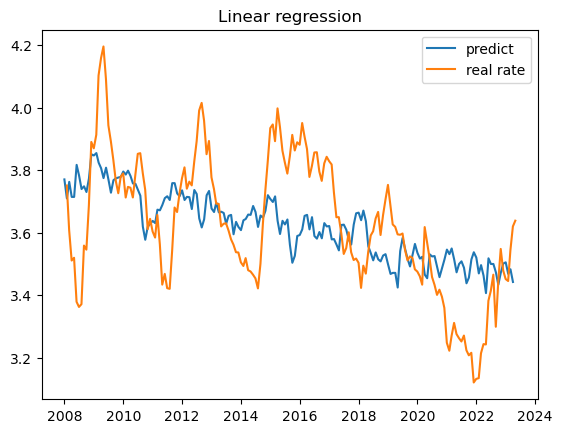

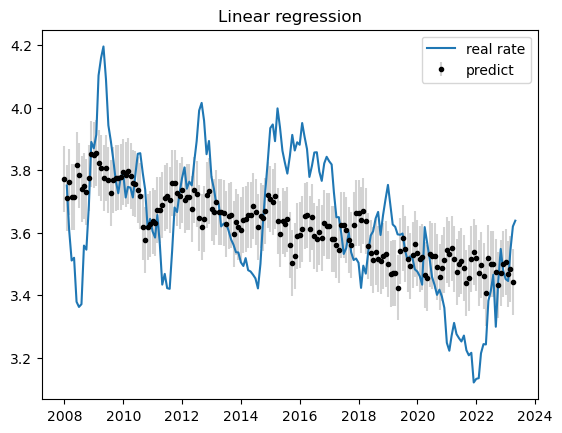

Training MSE: 0.0327
Testing MSE: 0.0347


In [13]:
#### describe = LinearRegression()

lr = LinearRegression()
lr.fit(X_train, y_train)

lr_Evaluate = Model_Evaluate(X_test, y_test, lr, 'Linear regression' )
plot_predict_and_std(startdt, enddt, y, lr.predict(X), 'Linear regression')
fitting_MSE(lr, X_train, X_test, y_train)

### Random forest regressor

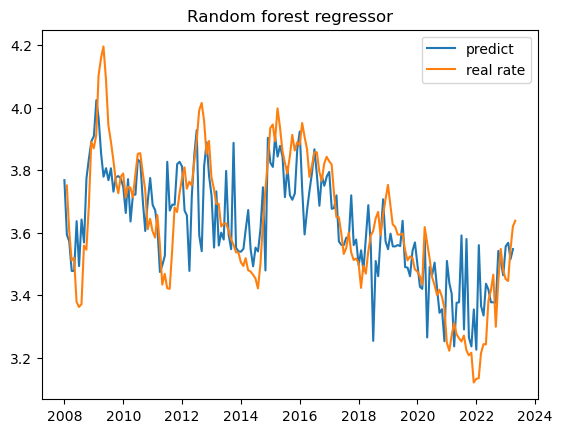

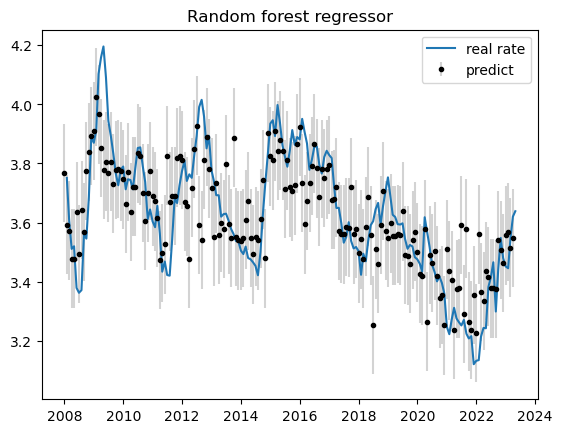

Training MSE: 0.0063
Testing MSE: 0.0564


In [14]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

#### Random forest regressor

rf_Evaluate =  Model_Evaluate(X_test, y_test, rf, 'Random forest regressor')
plot_predict_and_std(startdt, enddt, y, rf.predict(X), 'Random forest regressor')
fitting_MSE(rf, X_train, X_test, y_train)

### Evaluate results

In [15]:
pd.DataFrame([rf_Evaluate, lr_Evaluate]) 

,modle_name,MSE,r2_score
0,Random forest regressor,0.056401,0.017095
1,Linear regression,0.034698,0.395323


##  Prediction after dropin features

### Drop features with high correlations between them

In [16]:
end_data = new_df.drop(['Currency_in_Circulation', 'Trade_Foreign_Institutions', 'Trade_Foreign', 'Fruits_And_Vegetables'], axis=1)
corr = end_data.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=2)

,exchange_Rate,MCM,Foreign_exchange_Reserves,Trade_Bank,Trade_Residents,Offered_Rate
exchange_Rate,1.00,-0.07,-0.66,-0.10,-0.59,0.06
MCM,-0.07,1.00,0.39,-0.11,0.24,0.28
Foreign_exchange_Reserves,-0.66,0.39,1.00,0.05,0.73,-0.34
Trade_Bank,-0.10,-0.11,0.05,1.00,0.22,0.16
Trade_Residents,-0.59,0.24,0.73,0.22,1.00,0.04
Offered_Rate,0.06,0.28,-0.34,0.16,0.04,1.00


### Split and scale features

In [17]:
# Split the data into input and output variables
X = end_data.drop(['exchange_Rate'], axis=1)
y = end_data['exchange_Rate']

scale = StandardScaler()
X = scale.fit_transform(X)

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear regression

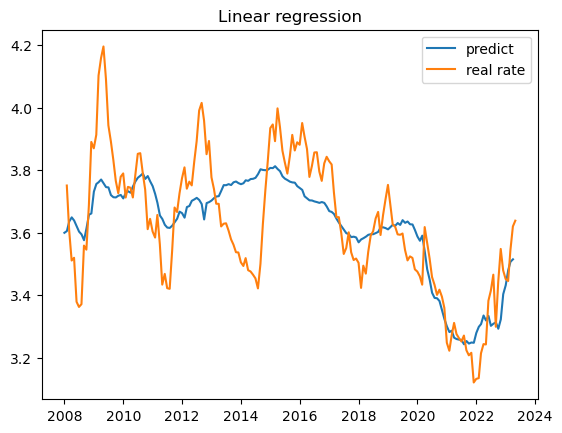

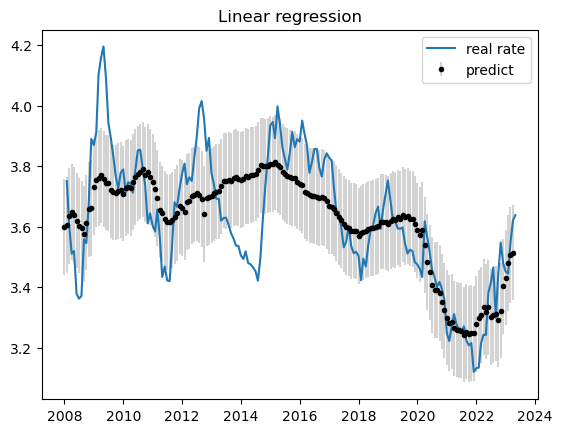

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)
title = 'Linear regression'
lr_Evaluate = Model_Evaluate(X_test, y_test, lr, 'Linear regression' )
plot_predict_and_std(startdt, enddt, y, lr.predict(X), title)
#fitting_MSE(lr, X_train, X_test, y_train)

### Random forest regressor

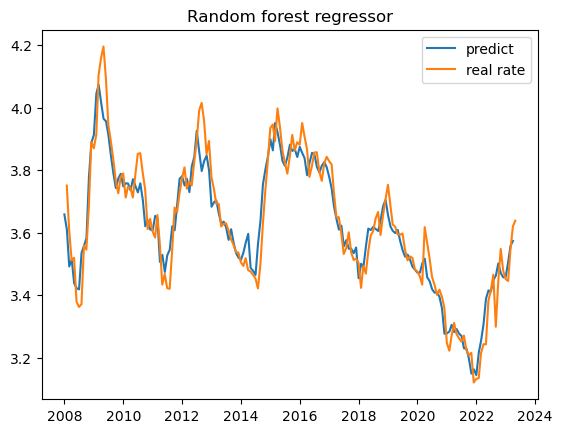

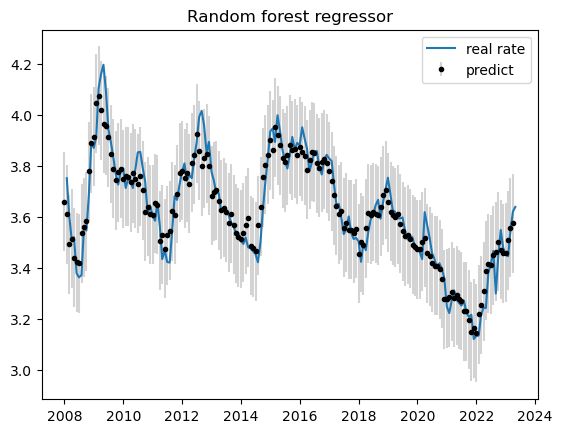

Training MSE: 0.0011
Testing MSE: 0.0064


In [19]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

rf_Evaluate =  Model_Evaluate(X_test, y_test, rf, 'Random forest regressor')
plot_predict_and_std(startdt, enddt, y, rf.predict(X), 'Random forest regressor')
fitting_MSE(rf, X_train, X_test, y_train)

### Evaluate results

In [20]:
full_eva = pd.DataFrame([rf_Evaluate, lr_Evaluate]) 
X_01 = end_data.drop(['exchange_Rate'], axis=1)
full_eva = add_Adj_R2(full_eva, X_train, X_01) 
full_eva

,modle_name,MSE,r2_score,Adj_R2
0,Random forest regressor,0.006434,0.887874,0.883898
1,Linear regression,0.024247,0.577448,0.562463


## Checking and correcting adjustments

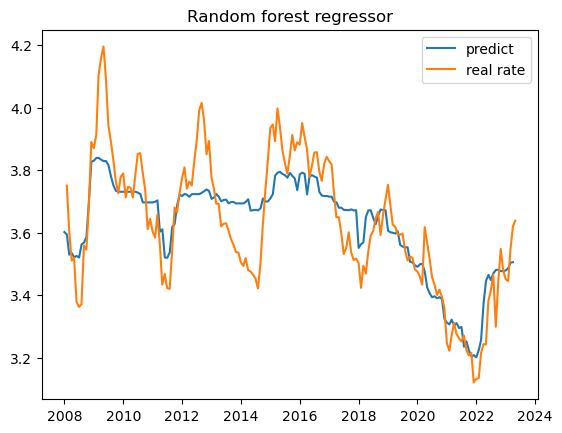

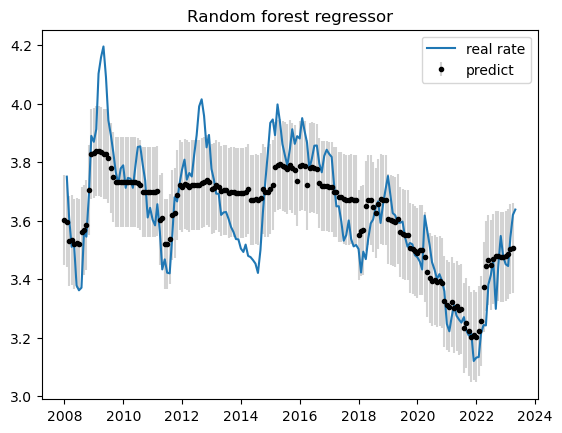

Training MSE: 0.0111
Testing MSE: 0.0190


{'modle_name': 'Random forest regressor',
 'MSE': 0.01900374449608312,
 'r2_score': 0.6688221908010361}

In [21]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth = 3 )
rf.fit(X_train, y_train)
plot_predict_and_std(startdt, enddt, y, rf.predict(X), 'Random forest regressor')
rf_Evaluate = Model_Evaluate(X_test, y_test, rf, 'Random forest regressor')
fitting_MSE(rf, X_train, X_test, y_train)
rf_Evaluate

## Results

In [22]:
full_eva = pd.DataFrame([rf_Evaluate, lr_Evaluate]) 
X_01 = end_data.drop(['exchange_Rate'], axis=1)
full_eva = add_Adj_R2(full_eva, X_train, X_01) 
full_eva

,modle_name,MSE,r2_score,Adj_R2
0,Random forest regressor,0.019004,0.668822,0.657078
1,Linear regression,0.024247,0.577448,0.562463
